In [128]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Base URL for the weather data API
base_url = "https://api.weather.gc.ca/collections/climate-hourly/items"
# Define the query parameters except offset (they must be URL-encoded as needed)
params = {
    "f": "json",
    "lang": "en-CA",
    "limit": 50000,  # maximum items per page
    "additionalProp1": "{}",
    "skipGeometry": "false",
    "datetime": "2016-01-01T00:00:00Z/2021-12-31T12:31:12Z",
    "CLIMATE_IDENTIFIER": "6144239"
}

climateList = []
offset = 0

while True:
    # Update the offset for pagination
    params["offset"] = offset
    r = requests.get(base_url, params=params)
    data = r.json()

    # Check how many features were returned
    features = data.get("features", [])
    if not features:
        break  # No more data, so exit the loop

    # Append each record's properties to the list
    for record in features:
        climateList.append(record["properties"])

    # Increase the offset by the limit to get the next page
    offset += params["limit"]

# Create a DataFrame from the collected data
dfweather_raw = pd.DataFrame(climateList)
print(dfweather_raw)

       LOCAL_DAY WEATHER_FRE_DESC CLIMATE_IDENTIFIER  WIND_DIRECTION  \
0              1               ND            6144239            23.0   
1              1               ND            6144239            25.0   
2              1               ND            6144239            25.0   
3              1               ND            6144239            24.0   
4              1            Neige            6144239            24.0   
...          ...              ...                ...             ...   
52551         31       Brouillard            6144239            11.0   
52552         31       Brouillard            6144239            14.0   
52553         31       Brouillard            6144239            15.0   
52554         31       Brouillard            6144239            19.0   
52555         31       Brouillard            6144239            22.0   

       UTC_YEAR WIND_DIRECTION_FLAG WEATHER_ENG_DESC TEMP_FLAG  \
0          2016                None               NA      None   
1  

In [129]:
base_url = "https://services1.arcgis.com/qAo1OsXi67t7XgmS/arcgis/rest/services/Traffic_Collisions/FeatureServer/0/query"
CollisionList = []

# For each year, page through results
for year in range(2016, 2022):
    offset = 0
    while True:
        # Build URL with pagination parameters: resultOffset and resultRecordCount
        collision_url = (
            f"{base_url}?where=ACCIDENT_YEAR={year}"
            f"&outFields=*"
            f"&returnGeometry=false"
            f"&resultOffset={offset}"
            f"&resultRecordCount=1000"  # adjust count if needed
            f"&f=json"
        )
        r = requests.get(collision_url)
        y = r.json()
        features = y.get("features", [])
        if not features:
            break  # No more records for this year
        for record in features:
            CollisionList.append(record["attributes"])
        offset += 1000  # Move to next page

dfcollisions_raw = pd.DataFrame(CollisionList)
print(dfcollisions_raw.shape)
print(dfcollisions_raw.head())
dfcollisions_raw.info



(7092, 40)
   OBJECTID ACCIDENTNUM   ACCIDENTDATE  ACCIDENT_YEAR  ACCIDENT_MONTH  \
0     44757   16-000325  1451651460000           2016               1   
1     44758   16-000330  1451610000000           2016               1   
2     44759   16-000393  1451652600000           2016               1   
3     44760   16-000423  1451661900000           2016               1   
4     44761   16-000511  1451672400000           2016               1   

   ACCIDENT_DAY  ACCIDENT_HOUR  ACCIDENT_MINUTE  ACCIDENT_SECOND  \
0             1             12               31                0   
1             1              1                0                0   
2             1             12               50                0   
3             1             15               25                0   
4             1             18               20                0   

  ACCIDENT_WEEKDAY  ...  PEDESTRIANINVOLVED  CYCLISTINVOLVED  \
0           Friday  ...               False            False   
1           F

<bound method DataFrame.info of       OBJECTID ACCIDENTNUM   ACCIDENTDATE  ACCIDENT_YEAR  ACCIDENT_MONTH  \
0        44757   16-000325  1451651460000           2016               1   
1        44758   16-000330  1451610000000           2016               1   
2        44759   16-000393  1451652600000           2016               1   
3        44760   16-000423  1451661900000           2016               1   
4        44761   16-000511  1451672400000           2016               1   
...        ...         ...            ...            ...             ...   
7087     52381   503028520  1634571600000           2021              10   
7088     52382   503056778  1636616040000           2021              11   
7089     52383   503098443  1640544300000           2021              12   
7090     52384   503098587  1640607000000           2021              12   
7091     52385   503098756  1640613600000           2021              12   

      ACCIDENT_DAY  ACCIDENT_HOUR  ACCIDENT_MINUTE  ACC

In [130]:
# To see all unique accident years
unique_years = dfcollisions_raw['ACCIDENT_YEAR'].unique()
print("Unique accident years:", unique_years)

# Alternatively, print the minimum and maximum accident year to get the range
min_year = dfcollisions_raw['ACCIDENT_YEAR'].min()
max_year = dfcollisions_raw['ACCIDENT_YEAR'].max()
print("Accidents from year", min_year, "to", max_year)
dfweather_raw['LOCAL_DATE'] = pd.to_datetime(dfweather_raw['LOCAL_DATE']) # Now dfweather_raw is defined

# Check that required columns exist (including ACCIDENT_HOUR)
required_cols = ['ACCIDENT_YEAR', 'ACCIDENT_MONTH', 'ACCIDENT_DAY', 'ACCIDENT_HOUR']
for col in required_cols:
    if col not in dfcollisions_raw.columns:
        raise ValueError(f"Column '{col}' is missing in dfcollisions_raw")

# Convert these columns to numeric
for col in required_cols:
    dfcollisions_raw[col] = pd.to_numeric(dfcollisions_raw[col], errors='coerce')

# Create the ACCIDENT_DATETIME column in one step by combining year, month, day, and hour.
# We use string concatenation and ensure that month, day, and hour are two digits (using zfill)
dfcollisions_raw['ACCIDENT_DATETIME'] = pd.to_datetime(
    dfcollisions_raw['ACCIDENT_YEAR'].astype(str) + '-' +
    dfcollisions_raw['ACCIDENT_MONTH'].astype(str).str.zfill(2) + '-' +
    dfcollisions_raw['ACCIDENT_DAY'].astype(str).str.zfill(2) + ' ' +
    dfcollisions_raw['ACCIDENT_HOUR'].astype(str).str.zfill(2) + ':00:00',
    errors='coerce'
)

# Print info about the new column to verify everything
dfcollisions_raw.info()
print(dfcollisions_raw[['ACCIDENT_DATETIME', 'ACCIDENT_YEAR', 'ACCIDENT_MONTH', 'ACCIDENT_DAY', 'ACCIDENT_HOUR']].head())

Unique accident years: [2016 2017 2018 2019 2020 2021]
Accidents from year 2016 to 2021
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7092 entries, 0 to 7091
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   OBJECTID                     7092 non-null   int64         
 1   ACCIDENTNUM                  7092 non-null   object        
 2   ACCIDENTDATE                 7092 non-null   int64         
 3   ACCIDENT_YEAR                7092 non-null   int64         
 4   ACCIDENT_MONTH               7092 non-null   int64         
 5   ACCIDENT_DAY                 7092 non-null   int64         
 6   ACCIDENT_HOUR                7092 non-null   int64         
 7   ACCIDENT_MINUTE              7092 non-null   int64         
 8   ACCIDENT_SECOND              7092 non-null   int64         
 9   ACCIDENT_WEEKDAY             7092 non-null   object        
 10  XCOORD              

In [131]:
# Round weather times to the hour
dfweather_raw['HOUR_DATETIME'] = dfweather_raw['LOCAL_DATE'].dt.floor('h')

# Merge collision data with nearest weather hour
df_merged = pd.merge(
    dfcollisions_raw,
    dfweather_raw,
    left_on='ACCIDENT_DATETIME',
    right_on='HOUR_DATETIME',
    how='left'
)

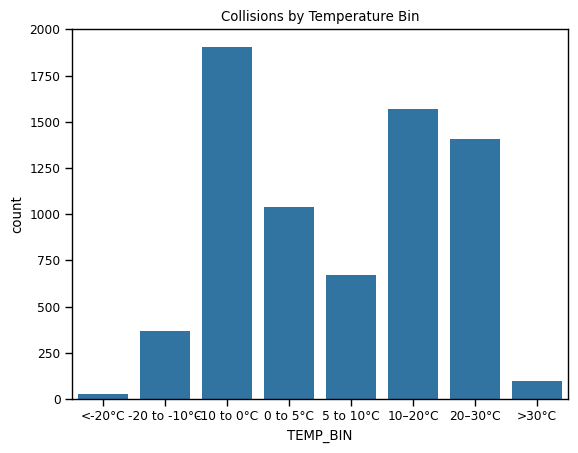

In [132]:
#Feature Engineering Create categorical bins for more meaningful analysis:

df_merged['TEMP_BIN'] = pd.cut(
    df_merged['TEMP'],
    bins=[-40, -20, -10, 0, 5, 10, 20, 30, 50],
    labels=[
        '<-20°C', '-20 to -10°C', '-10 to 0°C', '0 to 5°C',
        '5 to 10°C', '10–20°C', '20–30°C', '>30°C'
    ]
)

df_merged['VISIBILITY_BIN'] = pd.cut(df_merged['VISIBILITY'], bins=[-1, 2, 5, 10, 20], labels=['<2km', '2–5km', '5–10km', '10km+'])

sns.countplot(data=df_merged, x='TEMP_BIN') # Change df_analysis to df_merged
plt.title("Collisions by Temperature Bin")
sns.set_context("paper", font_scale=0.6)
plt.show()

C:\Users\markp\AppData\Local\Temp\ipykernel_15264\1525161325.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  visibility_counts = df_merged.groupby('VISIBILITY_BIN').size().reset_index(name='CollisionCount')
C:\Users\markp\AppData\Local\Temp\ipykernel_15264\1525161325.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='VISIBILITY_BIN', y='CollisionCount', data=visibility_counts, palette="viridis")


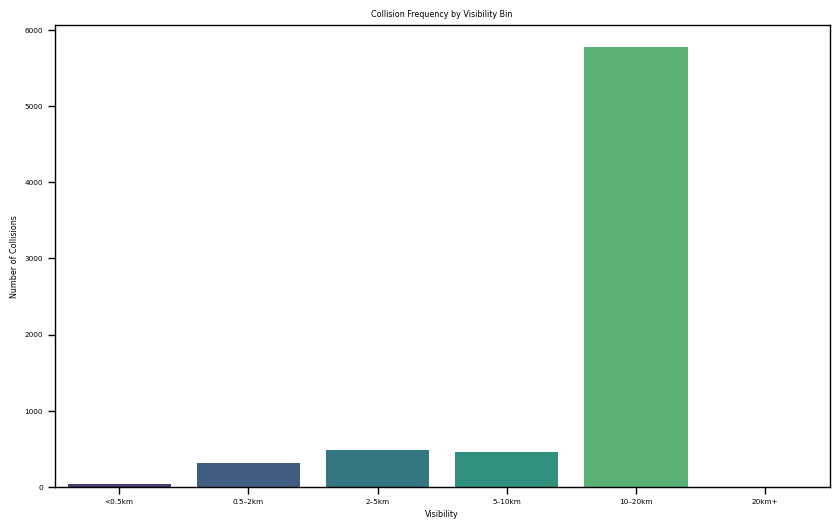

In [133]:
# Create visibility bins – adjust as needed for your region
df_merged['VISIBILITY_BIN'] = pd.cut(df_merged['VISIBILITY'],
                                     bins=[-1, 0.5, 2, 5, 10, 20, 50],
                                     labels=['<0.5km', '0.5–2km', '2–5km', '5–10km', '10–20km', '20km+'])

# Group collisions by visibility bin and count occurrences
visibility_counts = df_merged.groupby('VISIBILITY_BIN').size().reset_index(name='CollisionCount')

# Bar plot of collisions by visibility bin
plt.figure(figsize=(10, 6))
sns.barplot(x='VISIBILITY_BIN', y='CollisionCount', data=visibility_counts, palette="viridis")
plt.title("Collision Frequency by Visibility Bin")
plt.xlabel("Visibility")
plt.ylabel("Number of Collisions")
sns.set_context("paper", font_scale=1.0)
plt.show()


In [134]:
# Suppose dfweather_raw is your weather DataFrame
dfweather_raw['VISIBILITY_BIN'] = pd.cut(
    dfweather_raw['VISIBILITY'],
    bins=[-1, 0.5, 2, 5, 10, 20, 50],
    labels=['<0.5km', '0.5–2km', '2–5km', '5–10km', '10–20km', '20km+']
)

# Hours of weather in each bin
weather_hours = dfweather_raw.groupby('VISIBILITY_BIN').size().reset_index(name='WeatherHours')
print(weather_hours)
total_weather_hours = weather_hours['WeatherHours'].sum()
print(total_weather_hours)

df_merged['VISIBILITY_BIN'] = pd.cut(
    df_merged['VISIBILITY'],
    bins=[-1, 0.5, 2, 5, 10, 20, 50],
    labels=['<0.5km', '0.5–2km', '2–5km', '5–10km', '10–20km', '20km+']
)

collision_counts = df_merged.groupby('VISIBILITY_BIN').size().reset_index(name='CollisionCount')
print(collision_counts)


  VISIBILITY_BIN  WeatherHours
0         <0.5km           584
1        0.5–2km          1505
2          2–5km          3119
3         5–10km          3143
4        10–20km         44122
5          20km+             0
52473
  VISIBILITY_BIN  CollisionCount
0         <0.5km              40
1        0.5–2km             313
2          2–5km             478
3         5–10km             463
4        10–20km            5774
5          20km+               0


C:\Users\markp\AppData\Local\Temp\ipykernel_15264\1623725209.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weather_hours = dfweather_raw.groupby('VISIBILITY_BIN').size().reset_index(name='WeatherHours')
C:\Users\markp\AppData\Local\Temp\ipykernel_15264\1623725209.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  collision_counts = df_merged.groupby('VISIBILITY_BIN').size().reset_index(name='CollisionCount')


In [135]:
# Merge the two counts: weather hours and collision counts per visibility bin
# We use an outer merge to include all visibility bins, even if one dataset has zero records for that bin.
df_vis = pd.merge(
    weather_hours,      # DataFrame containing the count of weather observations per visibility bin
    collision_counts,   # DataFrame containing the count of collisions per visibility bin
    on='VISIBILITY_BIN',
    how='outer'
)

# After the merge, some bins might be missing in one of the DataFrames, resulting in NaN values.
# Fill NaN values in both 'CollisionCount' and 'WeatherHours' with 0,
# because if a bin is missing from one DataFrame it means there were 0 records for that bin.
df_vis['CollisionCount'] = df_vis['CollisionCount'].fillna(0)
df_vis['WeatherHours'] = df_vis['WeatherHours'].fillna(0)

# (Optional) If 'VISIBILITY_BIN' had NaNs (unlikely), you could fill them with a category like 'Unknown':
# df_vis['VISIBILITY_BIN'] = df_vis['VISIBILITY_BIN'].cat.add_categories(['Unknown']).fillna('Unknown')

# Calculate the collision rate: number of collisions per 1000 hours of weather data
# This normalizes the collision counts by the amount of time spent in that visibility bin.
df_vis['CollisionsPerThousandHours'] = (df_vis['CollisionCount'] / df_vis['WeatherHours']) * 1000

# Print the resulting DataFrame to review the computed values
print(df_vis)


  VISIBILITY_BIN  WeatherHours  CollisionCount  CollisionsPerThousandHours
0         <0.5km           584              40                   68.493151
1        0.5–2km          1505             313                  207.973422
2          2–5km          3119             478                  153.254248
3         5–10km          3143             463                  147.311486
4        10–20km         44122            5774                  130.864421
5          20km+             0               0                         NaN


C:\Users\markp\AppData\Local\Temp\ipykernel_15264\1978105319.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


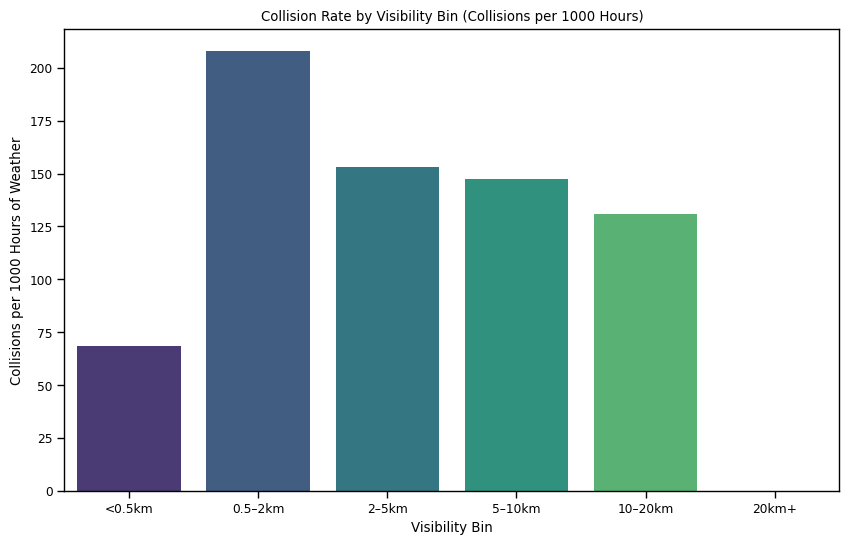

In [136]:

plt.figure(figsize=(10, 6))
sns.barplot(
    x='VISIBILITY_BIN',
    y='CollisionsPerThousandHours',
    data=df_vis,
    palette="viridis"
)
plt.title("Collision Rate by Visibility Bin (Collisions per 1000 Hours)")
plt.xlabel("Visibility Bin")
plt.ylabel("Collisions per 1000 Hours of Weather")
plt.show()


C:\Users\markp\AppData\Local\Temp\ipykernel_15264\2429606288.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  collision_counts = df_merged.groupby(['VISIBILITY_BIN', 'ACCIDENT_HOUR']).size().reset_index(name='CollisionCount')
C:\Users\markp\AppData\Local\Temp\ipykernel_15264\2429606288.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weather_hours = dfweather_raw.groupby(['VISIBILITY_BIN', 'HOUR']).size().reset_index(name='WeatherHours')


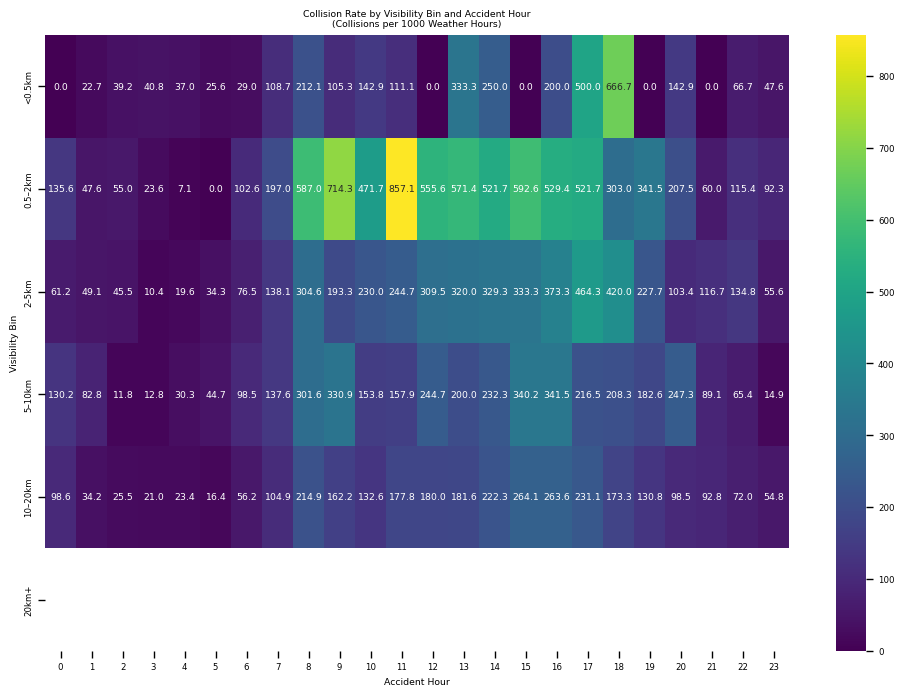

In [174]:

# --- Step 1: Create Accident Hour from ACCIDENT_DATETIME in df_merged ---
df_merged['ACCIDENT_HOUR'] = df_merged['ACCIDENT_DATETIME'].dt.hour

# --- Step 2: Count collisions by Visibility Bin and Accident Hour ---
collision_counts = df_merged.groupby(['VISIBILITY_BIN', 'ACCIDENT_HOUR']).size().reset_index(name='CollisionCount')

# --- Step 3: For normalization, count weather hours by Visibility Bin and Hour in the weather DataFrame ---
# Ensure that dfweather_raw has a column 'LOCAL_DATE' as datetime and a 'VISIBILITY_BIN'
dfweather_raw['HOUR'] = pd.to_datetime(dfweather_raw['LOCAL_DATE']).dt.hour
weather_hours = dfweather_raw.groupby(['VISIBILITY_BIN', 'HOUR']).size().reset_index(name='WeatherHours')

# --- Step 4: Merge the collision counts with weather hours on Visibility Bin and Hour ---
df_rate = pd.merge(collision_counts, weather_hours, left_on=['VISIBILITY_BIN', 'ACCIDENT_HOUR'],
                   right_on=['VISIBILITY_BIN', 'HOUR'], how='outer')

# --- Step 5: Replace NaN values with 0 for numeric counts ---
df_rate['CollisionCount'] = df_rate['CollisionCount'].fillna(0)
df_rate['WeatherHours'] = df_rate['WeatherHours'].fillna(0)

# --- Step 6: Calculate Collision Rate (collisions per 1000 weather hours) ---
df_rate['CollisionRate'] = (df_rate['CollisionCount'] / df_rate['WeatherHours']) * 1000

# --- Step 7: Pivot the data to create a 2D structure (rows: Visibility Bin, columns: Accident Hour) ---
pivot_rate = df_rate.pivot(index='VISIBILITY_BIN', columns='ACCIDENT_HOUR', values='CollisionRate')

# --- Step 8: Plot a heatmap of the collision rate ---
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_rate, annot=True, fmt=".1f", cmap="viridis")
plt.title("Collision Rate by Visibility Bin and Accident Hour\n(Collisions per 1000 Weather Hours)")
plt.xlabel("Accident Hour")
plt.ylabel("Visibility Bin")
sns.set_context("paper", font_scale=0.6)
plt.show()


C:\Users\markp\AppData\Local\Temp\ipykernel_15264\1877966522.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  precip_counts = df_merged.groupby('PRECIP_BIN').size().reset_index(name='CollisionCount')
C:\Users\markp\AppData\Local\Temp\ipykernel_15264\1877966522.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='PRECIP_BIN', y='CollisionCount', data=precip_counts, palette="magma")


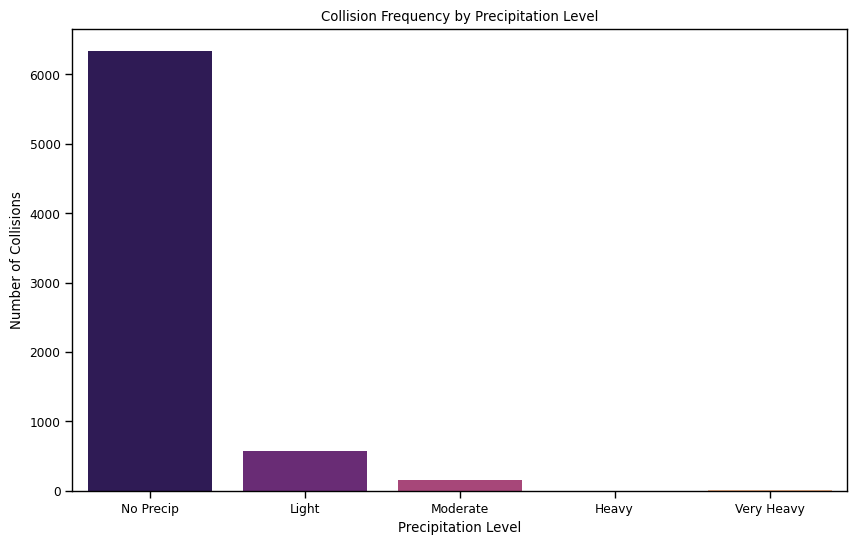

In [138]:
# Create bins for precipitation (assuming PRECIP_AMOUNT is in mm)
df_merged['PRECIP_BIN'] = pd.cut(df_merged['PRECIP_AMOUNT'],
                                 bins=[-0.1, 0, 1, 5, 10, 50],
                                 labels=['No Precip', 'Light', 'Moderate', 'Heavy', 'Very Heavy'])

# Group collisions by precipitation bin
precip_counts = df_merged.groupby('PRECIP_BIN').size().reset_index(name='CollisionCount')

plt.figure(figsize=(10, 6))
sns.barplot(x='PRECIP_BIN', y='CollisionCount', data=precip_counts, palette="magma")
plt.title("Collision Frequency by Precipitation Level")
plt.xlabel("Precipitation Level")
plt.ylabel("Number of Collisions")
plt.show()

C:\Users\markp\AppData\Local\Temp\ipykernel_15264\570056772.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wind_counts = df_merged.groupby('WIND_BIN').size().reset_index(name='CollisionCount')
C:\Users\markp\AppData\Local\Temp\ipykernel_15264\570056772.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='WIND_BIN', y='CollisionCount', data=wind_counts, palette="Blues_d")


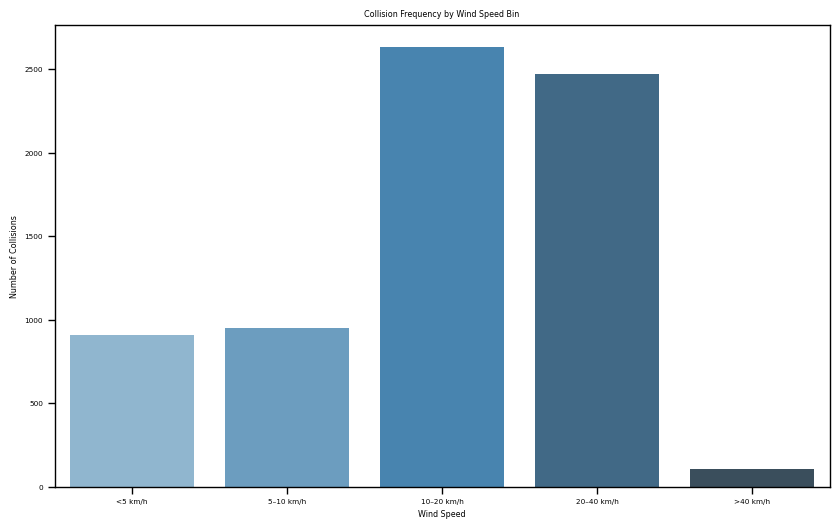

In [201]:
# Define wind speed bins (assuming WIND_SPEED is in km/h or similar)
df_merged['WIND_BIN'] = pd.cut(df_merged['WIND_SPEED'],
                               bins=[-1, 5, 10, 20, 40, 100],
                               labels=['<5 km/h', '5–10 km/h', '10–20 km/h', '20–40 km/h', '>40 km/h'])

wind_counts = df_merged.groupby('WIND_BIN').size().reset_index(name='CollisionCount')

plt.figure(figsize=(10, 6))
sns.barplot(x='WIND_BIN', y='CollisionCount', data=wind_counts, palette="Blues_d")
plt.title("Collision Frequency by Wind Speed Bin")
plt.xlabel("Wind Speed")
plt.ylabel("Number of Collisions")
plt.show()

C:\Users\markp\AppData\Local\Temp\ipykernel_15264\1566098904.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ACCIDENT_MONTH', y='CollisionCount', data=month_counts, palette="pastel")


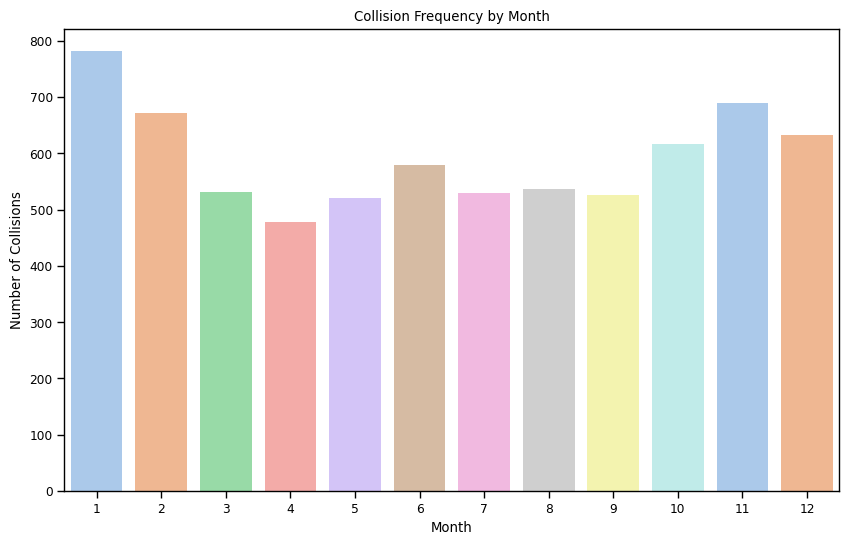

In [140]:
# Assume ACCIDENT_DATETIME exists and is of datetime type
df_merged['ACCIDENT_MONTH'] = df_merged['ACCIDENT_DATETIME'].dt.month

month_counts = df_merged.groupby('ACCIDENT_MONTH').size().reset_index(name='CollisionCount')

plt.figure(figsize=(10, 6))
sns.barplot(x='ACCIDENT_MONTH', y='CollisionCount', data=month_counts, palette="pastel")
plt.title("Collision Frequency by Month")
plt.xlabel("Month")
plt.ylabel("Number of Collisions")
plt.show()

C:\Users\markp\AppData\Local\Temp\ipykernel_15264\1822823706.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ACCIDENT_HOUR', data=df_merged, palette="rocket")


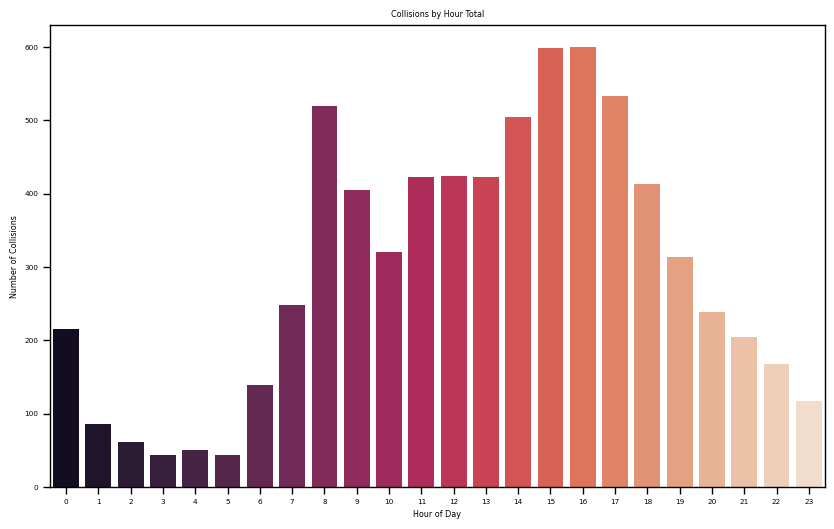

In [197]:
# Create a column for accident hour if not already done:
df_merged['ACCIDENT_HOUR'] = df_merged['ACCIDENT_DATETIME'].dt.hour

# Optionally, filter for adverse weather (e.g., low visibility or heavy precipitation)
adverse_conditions = df_merged[(df_merged['VISIBILITY'] < 2) | (df_merged['PRECIP_AMOUNT'] > 5)]



plt.figure(figsize=(10, 6))
sns.countplot(x='ACCIDENT_HOUR', data=df_merged, palette="rocket")
plt.title("Collisions by Hour Total")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Collisions")
plt.show()



C:\Users\markp\AppData\Local\Temp\ipykernel_15264\1737127901.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ENVIRONMENTCONDITION1', data=df_merged, palette="viridis")


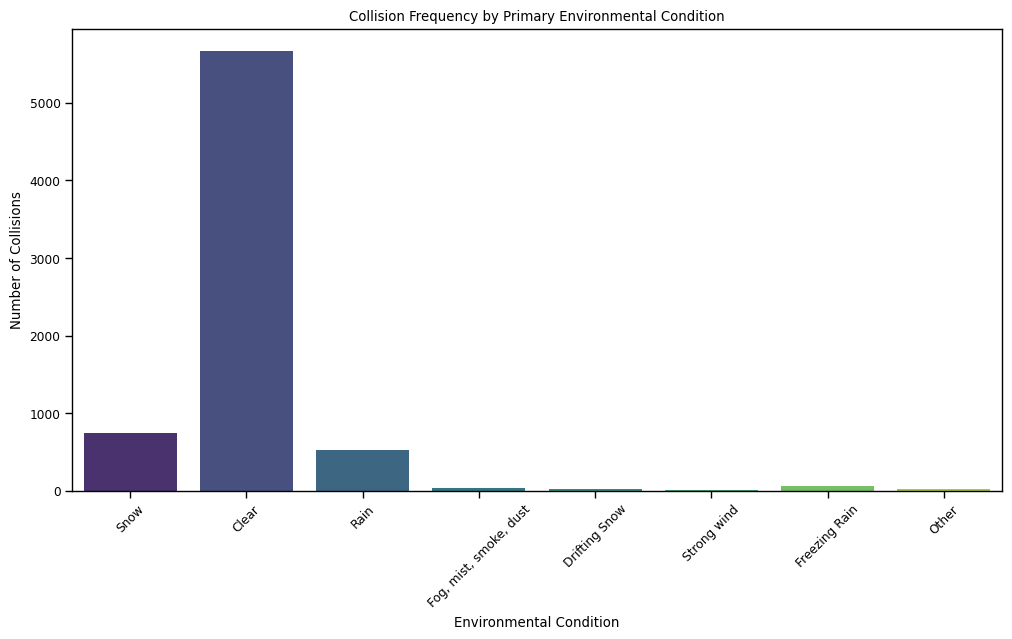

In [142]:
plt.figure(figsize=(12, 6))
sns.countplot(x='ENVIRONMENTCONDITION1', data=df_merged, palette="viridis")
plt.title("Collision Frequency by Primary Environmental Condition")
plt.xlabel("Environmental Condition")
plt.ylabel("Number of Collisions")
plt.xticks(rotation=45)
plt.show()

C:\Users\markp\AppData\Local\Temp\ipykernel_15264\3442326522.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ACCIDENT_YEAR', data=df_merged, palette="rocket")


<Figure size 1000x600 with 0 Axes>

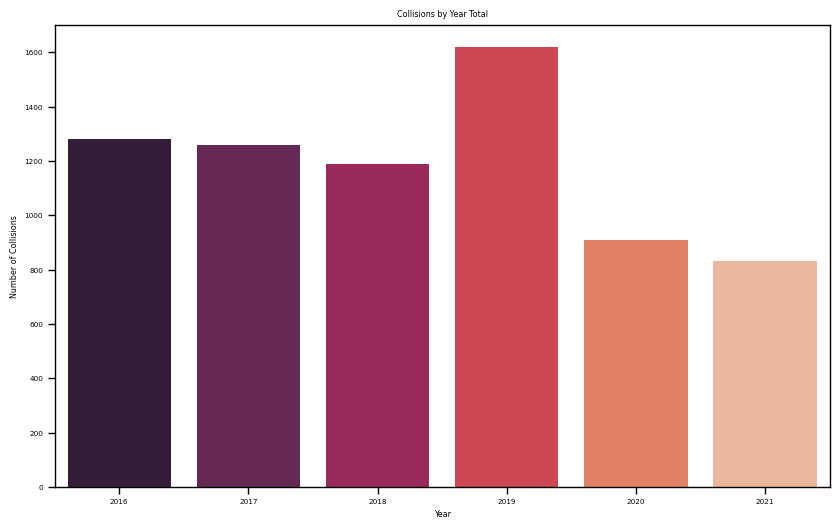

In [194]:
plt.figure(figsize=(10, 6))

plt.figure(figsize=(10, 6))
sns.countplot(x='ACCIDENT_YEAR', data=df_merged, palette="rocket")
plt.title("Collisions by Year Total")
plt.xlabel("Year")
plt.ylabel("Number of Collisions")
plt.show()

C:\Users\markp\AppData\Local\Temp\ipykernel_15264\3351903477.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ACCIDENT_WEEKDAY', data=df_merged, palette="rocket", order = days_of_week)


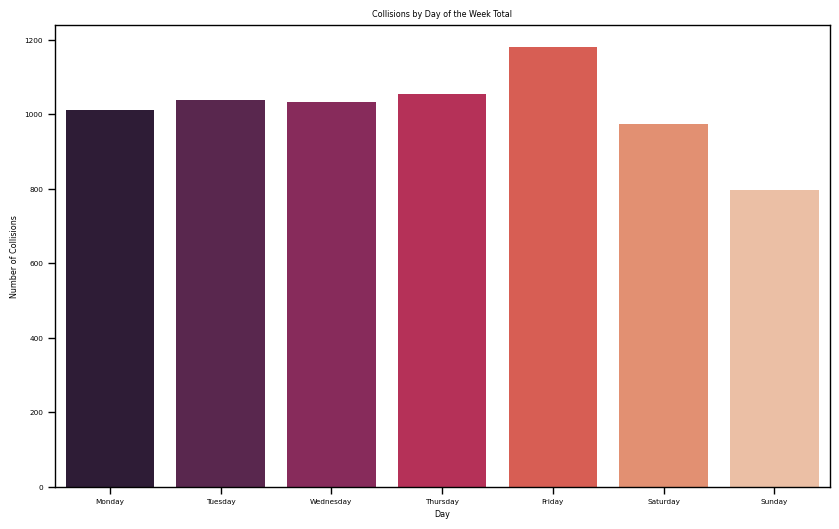

In [192]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


plt.figure(figsize=(10, 6))
sns.countplot(x='ACCIDENT_WEEKDAY', data=df_merged, palette="rocket", order = days_of_week)
plt.title("Collisions by Day of the Week Total")
plt.xlabel("Day")
plt.ylabel("Number of Collisions")
plt.show()

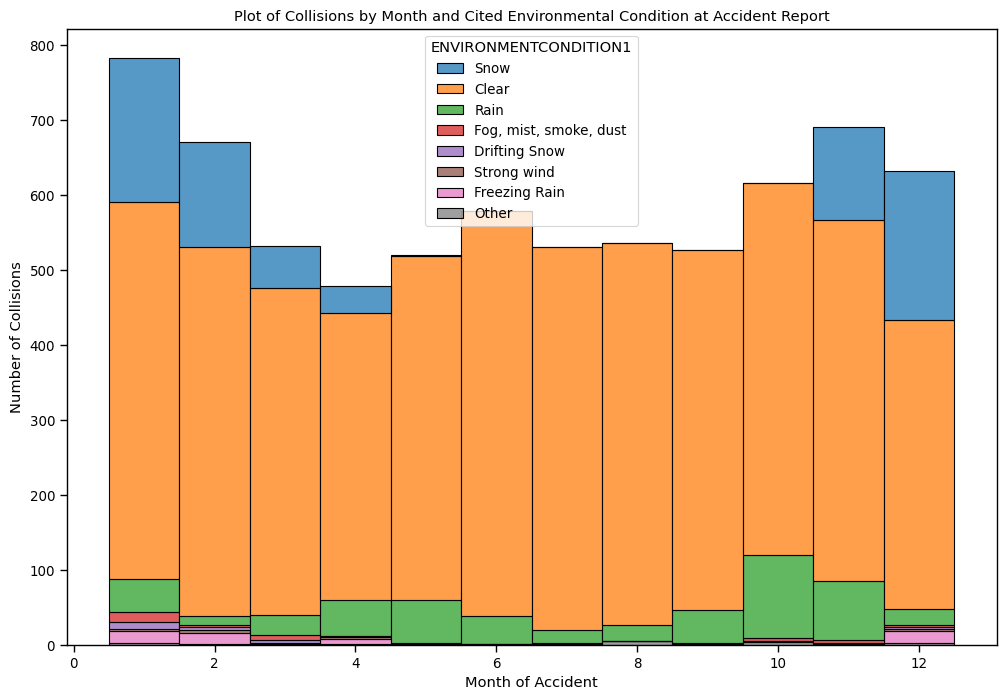

In [290]:
plt.figure(figsize=(12, 8))

sns.histplot(data=df_merged, x='ACCIDENT_MONTH', hue='ENVIRONMENTCONDITION1', multiple='stack', discrete=True)
plt.title("Plot of Collisions by Month and Cited Environmental Condition at Accident Report")
plt.xlabel("Month of Accident")
plt.ylabel("Number of Collisions")
plt.show()

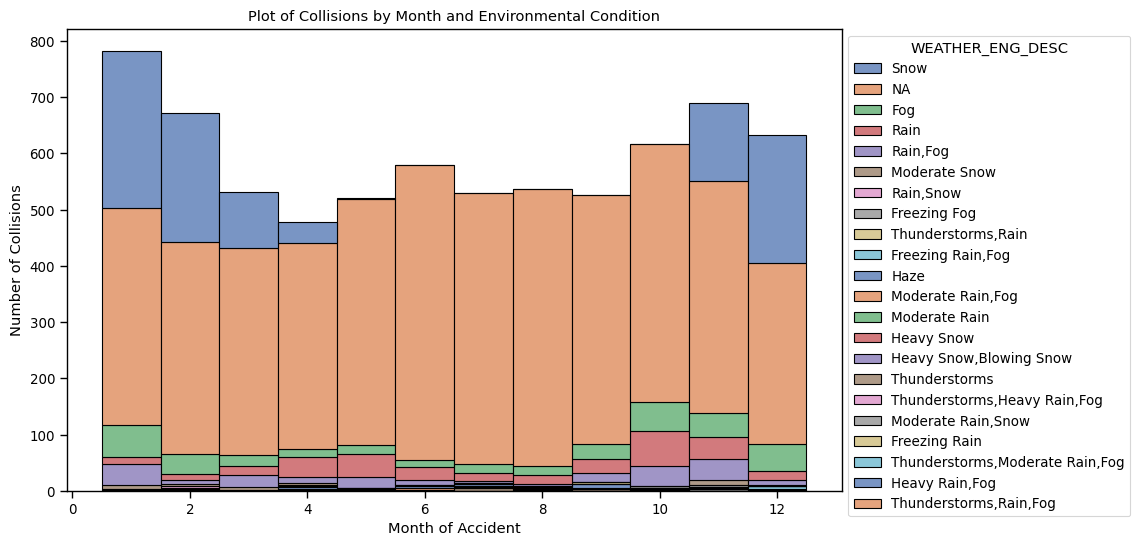

In [357]:
plt.figure(figsize=(10, 6))

SW=sns.histplot(data=df_merged, x='ACCIDENT_MONTH', palette="deep" , hue='WEATHER_ENG_DESC', multiple='stack', discrete=True)
plt.title("Plot of Collisions by Month and Environmental Condition")
plt.xlabel("Month of Accident")
plt.ylabel("Number of Collisions")
sns.move_legend(SW, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [302]:
#checking total number of accidents/weather types
print(df_merged['WEATHER_ENG_DESC'].unique())
weather_counts = df_merged['WEATHER_ENG_DESC'].value_counts()
print(weather_counts)
sum(weather_counts)

['Snow' 'NA' 'Fog' 'Rain' 'Rain,Fog' 'Moderate Snow' 'Rain,Snow'
 'Freezing Fog' 'Thunderstorms,Rain' 'Freezing Rain,Fog' 'Haze'
 'Moderate Rain,Fog' 'Moderate Rain' 'Heavy Snow'
 'Heavy Snow,Blowing Snow' 'Thunderstorms' nan
 'Thunderstorms,Heavy Rain,Fog' 'Moderate Rain,Snow' 'Freezing Rain'
 'Thunderstorms,Moderate Rain,Fog' 'Heavy Rain,Fog'
 'Thunderstorms,Rain,Fog']
WEATHER_ENG_DESC
NA                                 5056
Snow                               1013
Fog                                 354
Rain                                311
Rain,Fog                            211
Moderate Snow                        32
Haze                                 25
Moderate Rain,Fog                    19
Thunderstorms                        12
Freezing Fog                         10
Thunderstorms,Rain                    9
Freezing Rain,Fog                     7
Moderate Rain                         5
Rain,Snow                             4
Moderate Rain,Snow                    3
Freezing 

7082

In [311]:
#NaN is listed above in weather counts, how many are there?
nan_count = df_merged['WEATHER_ENG_DESC'].isna().sum()
print(f"Number of NaN values in 'WEATHER_ENG_DESC': {nan_count}")
# how to address these? - there is already an N/A category - assign to there?
df_merged['WEATHER_ENG_DESC'] = df_merged['WEATHER_ENG_DESC'].fillna('NA')
# redo previous calculation
print(df_merged['WEATHER_ENG_DESC'].unique())
weather_counts = df_merged['WEATHER_ENG_DESC'].value_counts()
print(weather_counts)
sum(weather_counts)

Number of NaN values in 'WEATHER_ENG_DESC': 10
['Snow' 'NA' 'Fog' 'Rain' 'Rain,Fog' 'Moderate Snow' 'Rain,Snow'
 'Freezing Fog' 'Thunderstorms,Rain' 'Freezing Rain,Fog' 'Haze'
 'Moderate Rain,Fog' 'Moderate Rain' 'Heavy Snow'
 'Heavy Snow,Blowing Snow' 'Thunderstorms' 'Thunderstorms,Heavy Rain,Fog'
 'Moderate Rain,Snow' 'Freezing Rain' 'Thunderstorms,Moderate Rain,Fog'
 'Heavy Rain,Fog' 'Thunderstorms,Rain,Fog']
WEATHER_ENG_DESC
NA                                 5066
Snow                               1013
Fog                                 354
Rain                                311
Rain,Fog                            211
Moderate Snow                        32
Haze                                 25
Moderate Rain,Fog                    19
Thunderstorms                        12
Freezing Fog                         10
Thunderstorms,Rain                    9
Freezing Rain,Fog                     7
Moderate Rain                         5
Rain,Snow                             4
Moderat

7092

In [347]:
# Isolate the accidents occurring by any types of snowy weather
snow_df=df_merged[df_merged['WEATHER_ENG_DESC'].str.contains('snow|freezing', case=False, na=False)]
snow_df.info

<bound method DataFrame.info of       OBJECTID ACCIDENTNUM   ACCIDENTDATE  ACCIDENT_YEAR  ACCIDENT_MONTH  \
0        44757   16-000325  1451651460000           2016               1   
2        44759   16-000393  1451652600000           2016               1   
4        44761   16-000511  1451672400000           2016               1   
5        44762   16-000523  1451674200000           2016               1   
6        44763   16-000912  1451678400000           2016               1   
...        ...         ...            ...            ...             ...   
7068     52210    22143158  1638261000000           2021              11   
7069     52275    22158751  1637582400000           2021              11   
7070     52318    22173215  1637656200000           2021              11   
7071     52365   502957571  1614679200000           2021               3   
7090     52384   503098587  1640607000000           2021              12   

      ACCIDENT_DAY  ACCIDENT_HOUR  ACCIDENT_MINUTE  ACC

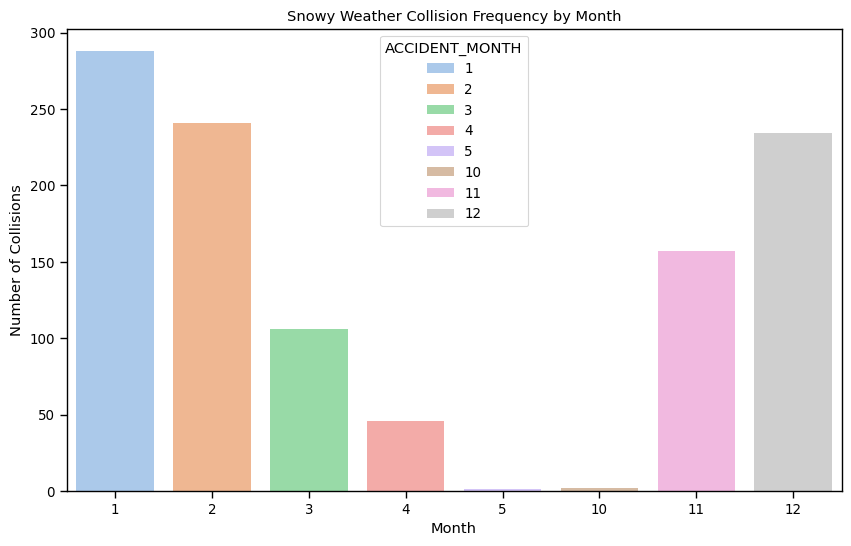

In [349]:


month_counts = snow_df.groupby('ACCIDENT_MONTH').size().reset_index(name='CollisionCount')

plt.figure(figsize=(10, 6))
sns.barplot(x='ACCIDENT_MONTH', y='CollisionCount', data=month_counts, palette="pastel", hue='ACCIDENT_MONTH')
plt.title("Snowy Weather Collision Frequency by Month")
plt.xlabel("Month")
plt.ylabel("Number of Collisions")
plt.show()

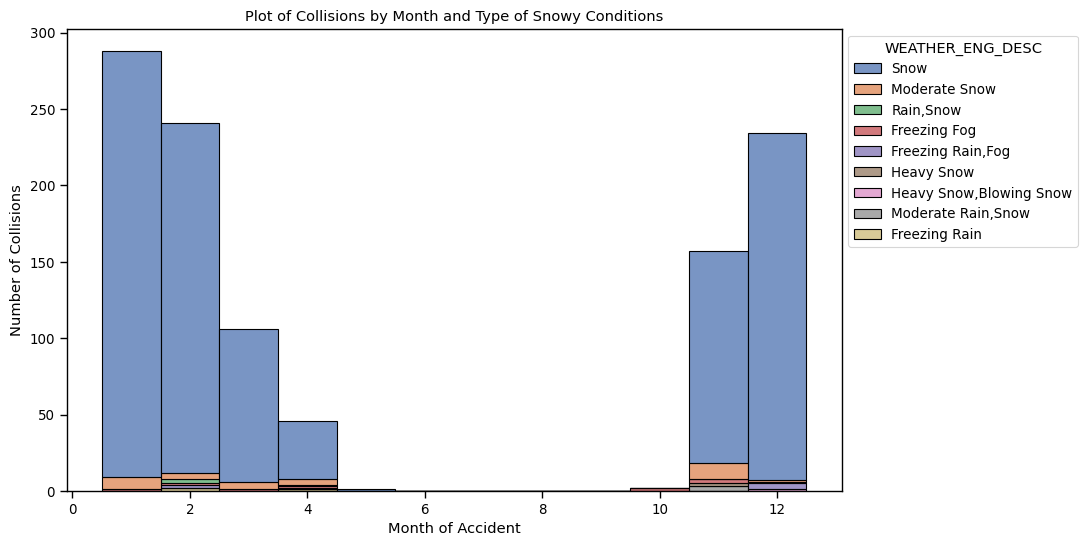

In [351]:
plt.figure(figsize=(10, 6))

SW=sns.histplot(data=snow_df, x='ACCIDENT_MONTH', palette="deep" , hue='WEATHER_ENG_DESC', multiple='stack', discrete=True)
plt.title("Plot of Collisions by Month and Type of Snowy Conditions")
plt.xlabel("Month of Accident")
plt.ylabel("Number of Collisions")
sns.move_legend(SW, "upper left", bbox_to_anchor=(1, 1))
plt.show()

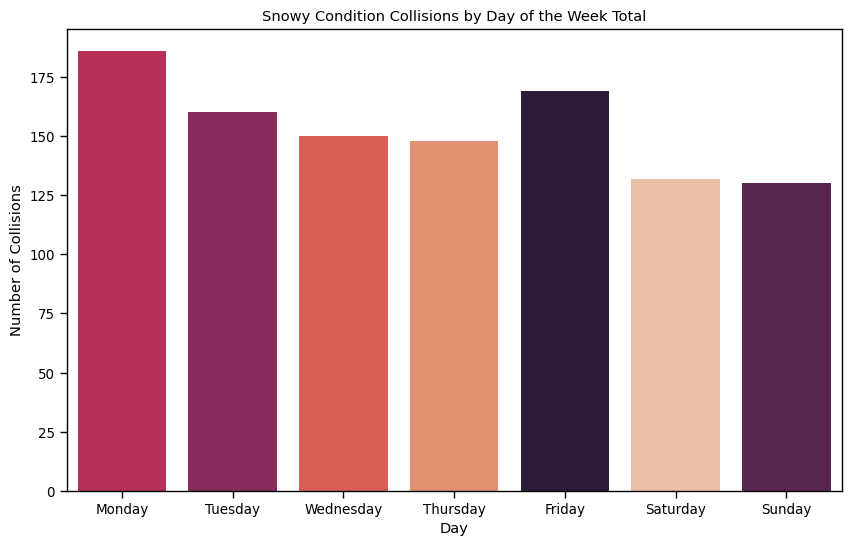

In [353]:
plt.figure(figsize=(10, 6))
sns.countplot(x='ACCIDENT_WEEKDAY', data=snow_df, palette="rocket", hue='ACCIDENT_WEEKDAY', order = days_of_week)
plt.title("Snowy Condition Collisions by Day of the Week Total")
plt.xlabel("Day")
plt.ylabel("Number of Collisions")
plt.show()

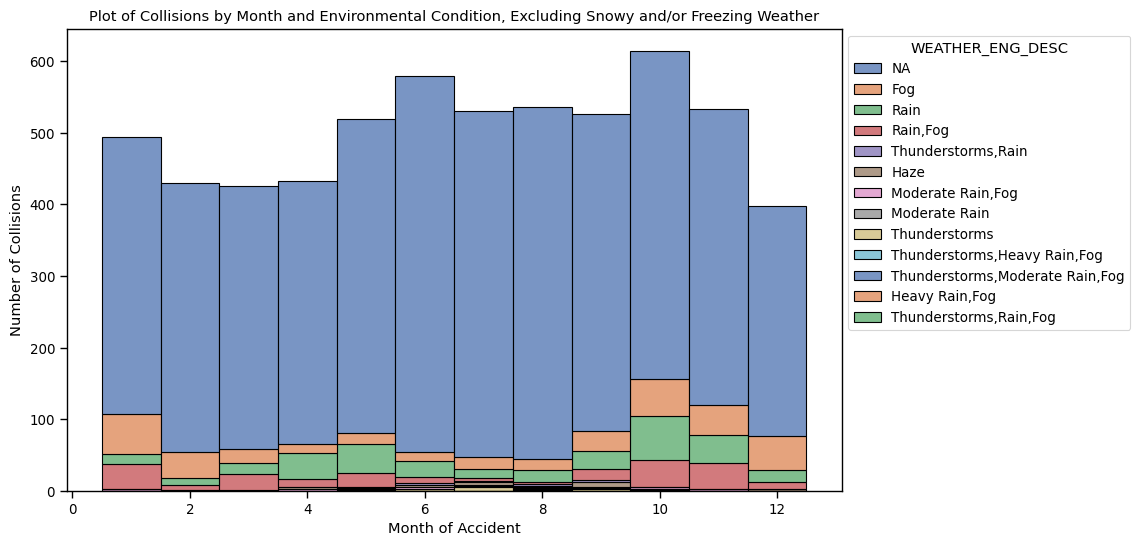

In [363]:
filtered_df=df_merged[~df_merged['WEATHER_ENG_DESC'].str.contains('snow|freezing', case=False, na=False)]


plt.figure(figsize=(10, 6))
NSW=sns.histplot(data=filtered_df, x='ACCIDENT_MONTH', palette="deep" , hue='WEATHER_ENG_DESC', multiple='stack', discrete=True)
plt.title("Plot of Collisions by Month and Environmental Condition, Excluding Snowy and/or Freezing Weather")
plt.xlabel("Month of Accident")
plt.ylabel("Number of Collisions")
sns.move_legend(NSW, "upper left", bbox_to_anchor=(1, 1))
plt.show()